In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras_tuner

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression


from functools import reduce
from functions import *

# 1. Observational data

## Newport Meteorological Station
- Station name: Newport (Furnace), Station altitude: 14 m.
- Latitude: 53.923, Longitude: -9.571


In [31]:
tas_obs = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Observational\Irish Meteorological Institute\dly833.csv', skiprows=13, parse_dates=['date'], na_values= ' ') # Not available numbers are given by blank space
tas_obs = tas_obs[['date', 'maxt', 'mint', 'rain']] # Drop the columns indicator, soil, grass
tas_obs.columns = ['date', 'tasmax_obs', 'tasmin_obs', 'pr_obs'] # Rename columns to ISIMIP naming scheme
tas_obs = tas_obs[(tas_obs['date'].dt.year >= 1961)&(tas_obs['date'].dt.year < 2020)].reset_index(drop = True) # Remove observations older than 1961 and newer than 2019 to match with ISIMIP datasets and reset index
tas_obs['tas_obs'] = (tas_obs.tasmax_obs + tas_obs.tasmin_obs)/2 # Calculate daily mean temperature (simplified)
tas_obs

,date,tasmax_obs,tasmin_obs,pr_obs,tas_obs
0,1961-01-01,8.8,4.9,10.7,6.85
1,1961-01-02,5.6,4.5,14.9,5.05
2,1961-01-03,7.1,0.7,11.8,3.90
3,1961-01-04,8.7,2.2,6.1,5.45
4,1961-01-05,7.2,1.1,7.8,4.15
...,...,...,...,...,...
21544,2019-12-27,12.0,8.2,4.5,10.10
21545,2019-12-28,12.3,9.0,0.0,10.65
21546,2019-12-29,13.3,9.4,3.0,11.35
21547,2019-12-30,11.0,10.5,0.5,10.75


## Mill Race Gauging Station
- Station name: Mill Race, Station altitude: Unknown 
- Latitude: 53.924, Latitude: -9.571

In [32]:
wt_obs = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Observational\Marine Institute\Environmental\millrace_temp_dec_2021.csv', parse_dates=['datetime'])
wt_obs.columns = ['date', 'wt'] # Rename columns
wt_obs.wt.interpolate('linear', inplace = True)
wt_obs = wt_obs[(wt_obs['date'].dt.year >= 1961)&(wt_obs['date'].dt.year < 2020)].reset_index(drop = True) # Remove observations older than 1961 and newer than 2019 to match with ISIMIP datasets and reset index

# 2. ISIMIP Simulation data
## Atmospheric Variables
- Simulation round: ISIMIP3a
- Model: GSWP3-W5E5 Obsclim
- Latitude: 53.65, Longitude: -9.75 (0.5x0.5 lat/lon grid)

- Atmospheric variables:
    - Near-surface air temperature (K),  (abbr, tas)
    - Near-surface maximum air temperature (K), (abbr, tasmax)
    - Near-surface minimum air temperature (K), (abbr, tasmin)
    - Precipitation (kg m-2 s-1), (abbr, pr)
    - Snowfall flux (kg m-2 s-1), (abbr, prsn)
    - Near-surface specific humidity (1), (abbr, huss)
    - Near-surface relative humidity (%), (abbr, hurs)
    - Near-surface wind speed (m s-1), (abbr, scfwind)
    - Surface downwelling shortwave radiation (W m-2)
    - Surface downwelling longwave radiation (W m-2)

In [33]:
climate_variables = ['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind'] # Store abbreviations in list
ds = pd.DataFrame() # Create dataframe to store atmospheric variables
for climate_variable in climate_variables:  # Loop through each variable in the list
    if climate_variable in ['tas', 'tasmax', 'tasmin']: # If variable is measured in kelvin convert to celsius and store in dataframe
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = kelvinToCelsius)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])
    elif climate_variable in ['pr', 'prsn', 'sfcwind']: # If variable is measured as average per second retain possibility to convert to per hour, per day, etc. 
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = None)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])
    elif climate_variable in ['huss', 'hurs', 'rsds', 'rlds']: # If variable is measured without any specific time denominator, or only contains per square meter (we could convert to catchment total, but refrain from that currently)
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = None)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])

ds.reset_index(inplace = True, drop = True) # Reset the index 
ds = ds.pivot(index = 'date', columns = ['climate_variable']) # Pivot and set date to index and columns to atmospheric variables
ds = ds.droplevel(level = 0, axis = 1) # Drop multilevel axis 
ds.index = pd.to_datetime(ds.index) # Encode date index to datetime
ds.reset_index(inplace = True) # Remove date as index, and number it

# Data Inspection
## ISIMIP3a Atmospheric Variable Validation

The ISIMIP3a surface temperature is on average shifted by -1.368151297665629 degress celsius. We could perform a mean-shift if we assume equal variance.


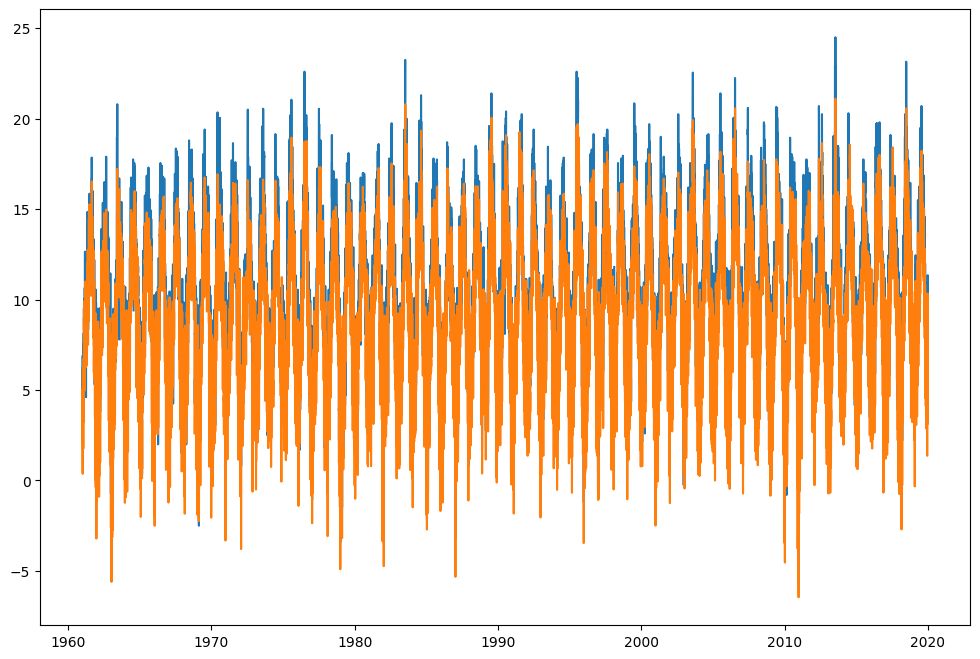

In [34]:
plt.plot(tas_obs.date, tas_obs.tas_obs)
plt.plot(ds.date, ds.tas)
print(rf'The ISIMIP3a surface temperature is on average shifted by {(ds.tas-tas_obs.tas_obs).mean()} degress celsius. We could perform a mean-shift if we assume equal variance.')

The ISIMIP3a precipitation is on average -4.345452062858772 kg m-2 lower per day. Again we could mean shift assuming equal variance


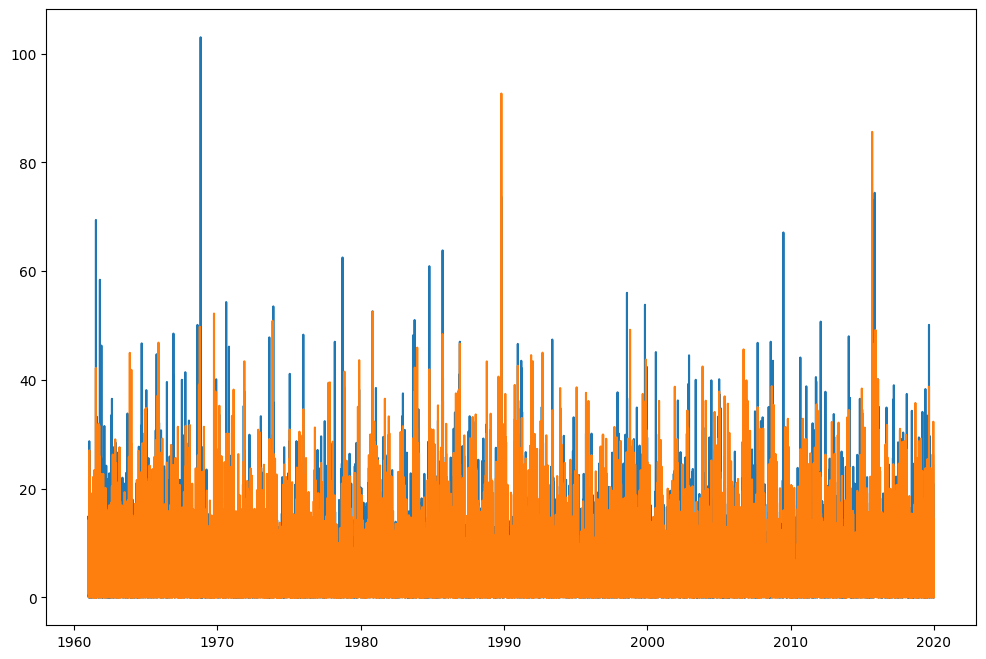

In [35]:
plt.plot(tas_obs.date, tas_obs.pr_obs)
plt.plot(ds.date, ds.pr*(60*60*24)) # Originally in per second, and not daily total
print(f'The ISIMIP3a precipitation is on average {(ds.pr-tas_obs.pr_obs).mean()} kg m-2 lower per day. Again we could mean shift assuming equal variance')

Since we are building a correlative model, we could assume that the bias in the GSWP3-W5E5 will be corrected by the model coefficients/weights. We will therefore forego the mean-shifting and merge the observational water temperature with the ISIMIP3a simulated atmospheric variables.

In [36]:
df = pd.merge(wt_obs, ds, on = 'date', how = 'inner')

# Time Series Analysis
## Time Series Decomposition
To better understand the underlying patterns in the timeseries, we perform a time series decomposition. 

The time series consists of three components, seasonal ($S_t$), trend-cycle ($T_t$) and reminder/residual ($R_t$).

$$ y_t = S_t + T_t + R_t $$

By decomposing it, we can obtain the three different constitutents. How these are devided depend on the method in use. Here we use the loess decomposition and classical decomposition methods. Note that this is only to get a better understanding of the data, and the future models may account for the different parts in their structure.

In [37]:
wt_interp = df.wt.interpolate(method = 'linear') # The statsmodels time series decomposition requires there to be no missing values.

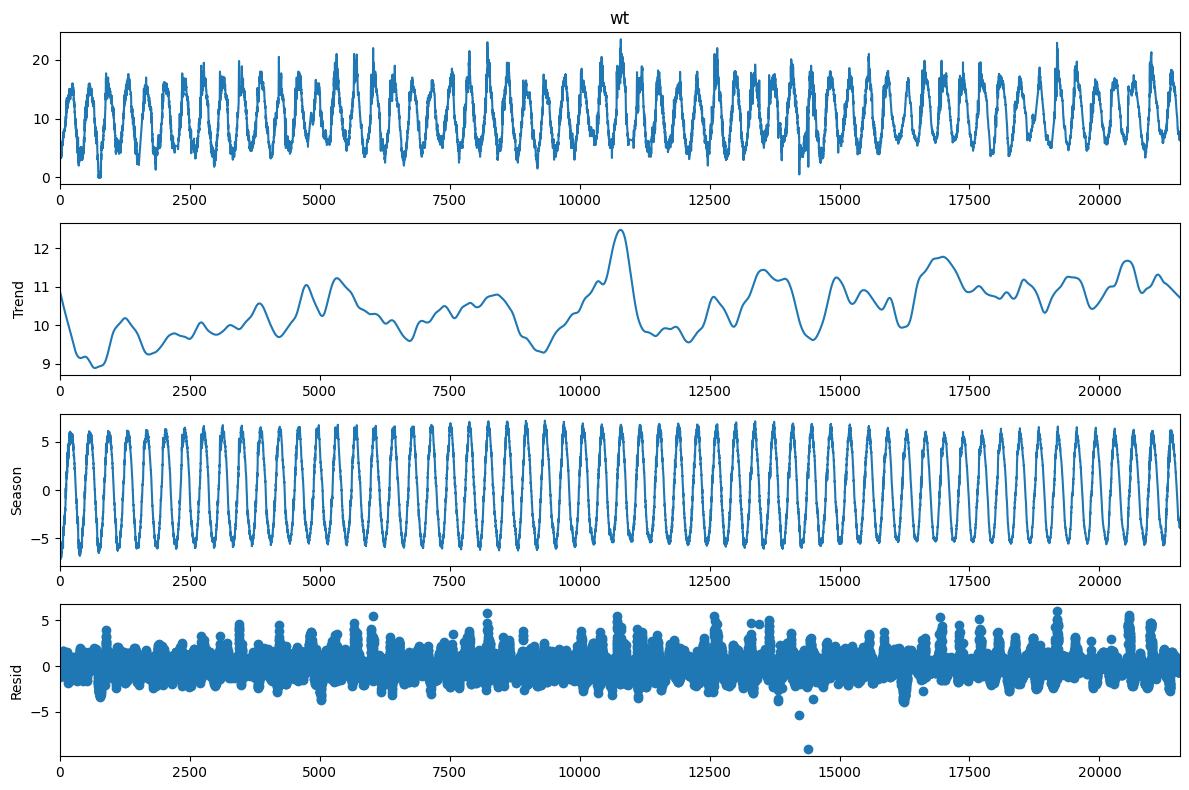

In [38]:
stl = STL(wt_interp, seasonal = 13, period = 365) # The trend-cycle component - Somewhat unfamiliar with how to specify
stl_res = stl.fit()
plt.rcParams["figure.figsize"] = (12,8)
stl_res.plot();

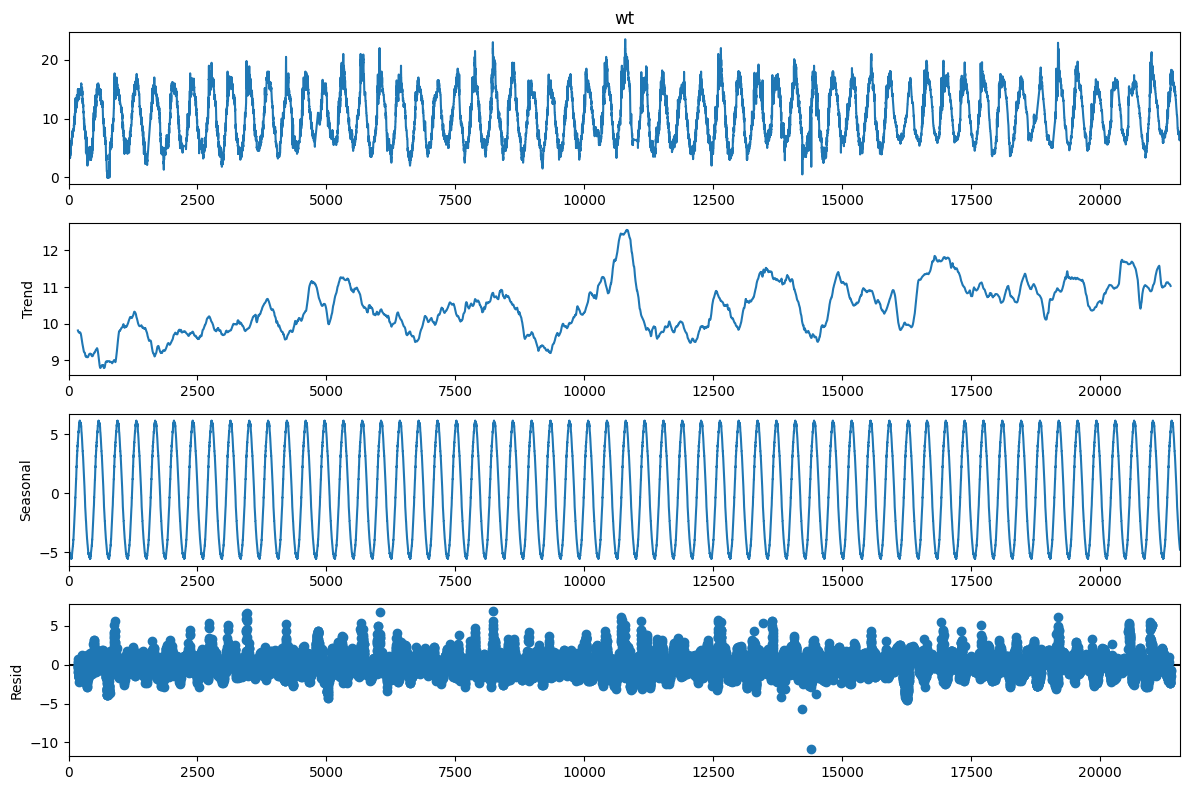

In [39]:
sede = seasonal_decompose(wt_interp, period = 365) 
sede.plot();

The time series seem to have an positive long-term trend component consistent with global warming. The first method does not seem to capture the clear North Atlantic Occilations, but it seems there is evidence of one in the 'Season' component.

## Fast Fourier Transform

Just get the frequency of the signals

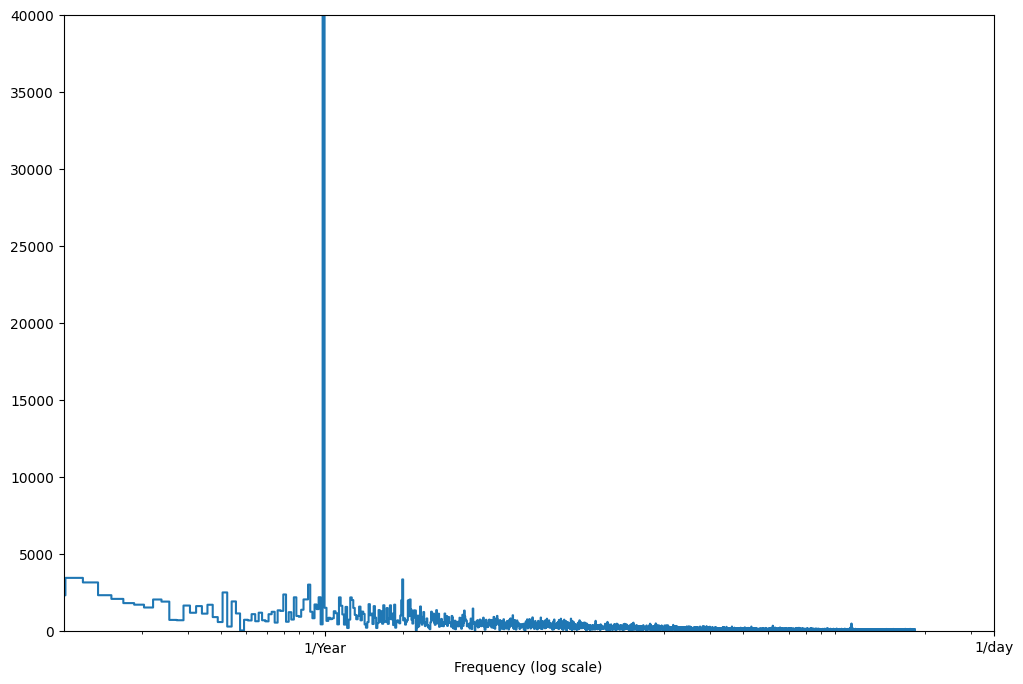

In [40]:
fft = tf.signal.rfft(df['wt'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df['wt'].dropna())
days_per_year = 365
years_per_dataset = n_samples/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Autocorrelation
For the fun of it

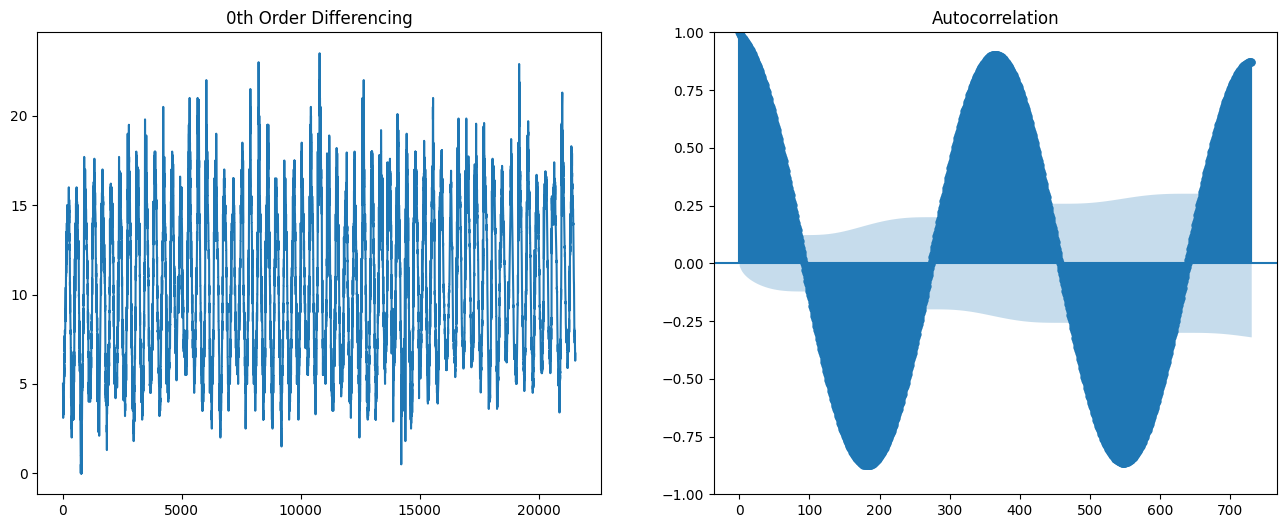

In [41]:
f = plt.figure(figsize = (16,6))
ax1 = f.add_subplot(121)
ax1.set_title('0th Order Differencing')
ax1.plot(df.wt)
ax2 = f.add_subplot(122)
plot_acf(df.wt, lags = 2*365, ax = ax2)
plt.show()

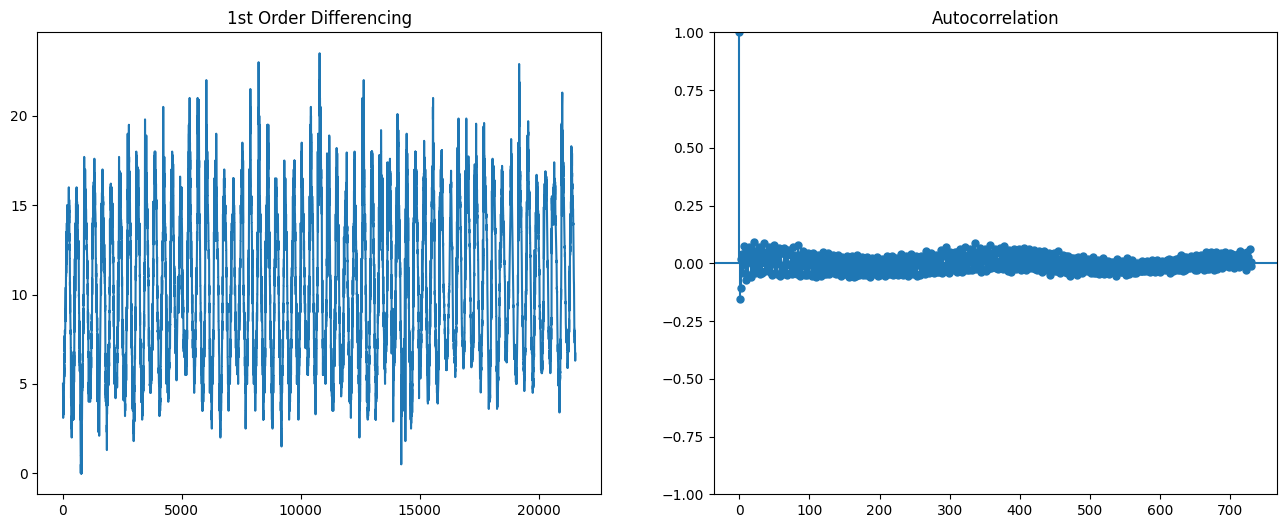

In [42]:
f = plt.figure(figsize = (16,6))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.wt)
ax2 = f.add_subplot(122)
plot_acf(df.wt.diff(1).dropna(), lags = 2*365, ax = ax2)
plt.show()

# Feature Engineering 

In [43]:
df['dayofyear'] = df.date.dt.dayofyear # Get the day of year
df = encode(df, 'dayofyear', 365) # Sine cosine transformation - Seasonality signal
df.drop('dayofyear', axis = 1, inplace = True) # Drop day of year

In [44]:
Lagging(lag = 7, cols =  climate_variables, data = df) # Get short-term lags 
Periodicity(period = 365, cols =  climate_variables, data = df) # Get year lags

In [45]:
Lagging(lag = 1, cols = ['wt'], data = df) # See if autoregressive make sense

# Feature Correlation

In [46]:
features = ['wt', 'wt_lag_1', 'tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_cos','dayofyear_sin'] # To extract features without lags
df[features].corr().wt.sort_values(ascending = False)

wt               1.000000
wt_lag_1         0.992726
tas              0.857340
tasmax           0.848538
tasmin           0.802081
huss             0.791949
rlds             0.607109
rsds             0.525953
hurs             0.019107
pr              -0.089548
prsn            -0.100328
sfcwind         -0.234676
dayofyear_sin   -0.556916
dayofyear_cos   -0.765756
Name: wt, dtype: float64

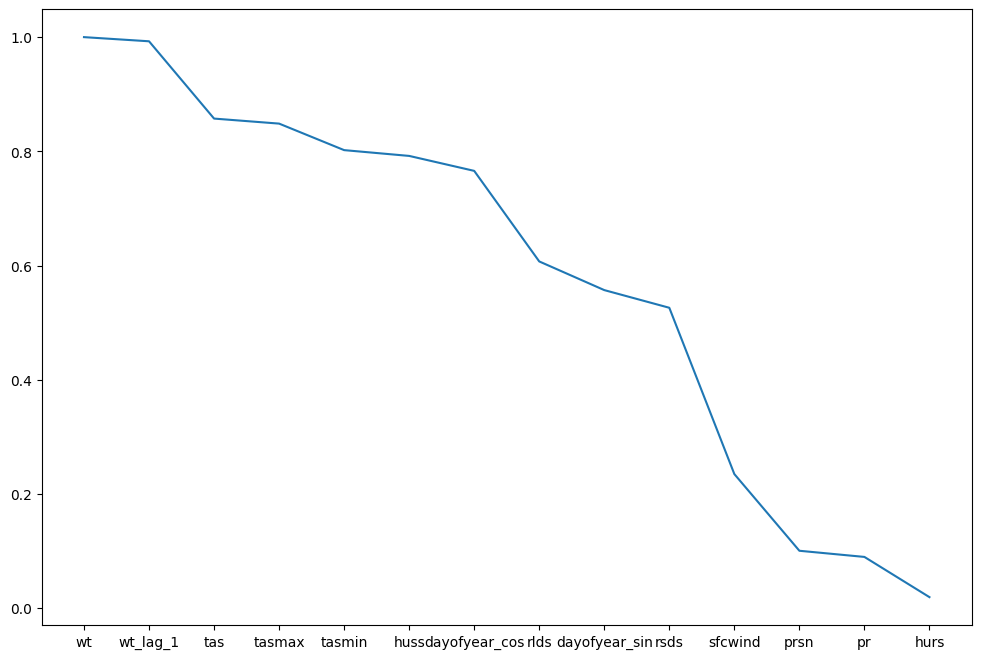

In [47]:
plt.plot(df[features].corr().abs().wt.sort_values(ascending = False)) # Plot the absolute value of the correlation 

To predict the future water temperature, yesterdays water temperature is the most important. Might be worth trying an autoregressive model. For the Burrishoole snowfall, precipiation and relative humidity seems the least important. 

# Train Test Split and Data Preparation

In [48]:
df.drop('wt_lag_1', axis = 1, inplace = True)

In [49]:
train_df = df[df['date'].dt.year < 2001] 
test_df = df[df['date'].dt.year >= 2001]

In [50]:
x_train = train_df.loc[:, (train_df.columns != 'wt')&(train_df.columns != 'date')]
y_train = train_df[['wt']]

x_test = test_df.loc[:, (test_df.columns != 'wt')&(train_df.columns != 'date')]
y_test = test_df[['wt']]

In [51]:
x_scalable_cols = x_train.loc[:, (x_train.columns != 'dayofyear_cos')&(x_train.columns != 'dayofyear_sin')].columns

In [52]:
feature_scaler = RobustScaler()
target_scaler = RobustScaler()
x_scaler = feature_scaler.fit(x_train[x_scalable_cols])
y_scaler = target_scaler.fit(y_train)

In [53]:
x_train.loc[:, x_scalable_cols] = x_scaler.transform(x_train[x_scalable_cols])
y_train = y_scaler.transform(y_train)

x_train = pd.DataFrame(x_train, columns = x_train.columns)
y_train = pd.DataFrame(y_train, columns = y_scaler.feature_names_in_)

x_test.loc[:, x_scalable_cols] = x_scaler.transform(x_test[x_scalable_cols])
y_test = y_scaler.transform(y_test)

x_test = pd.DataFrame(x_test, columns = x_train.columns)
y_test = pd.DataFrame(y_test, columns = y_scaler.feature_names_in_)

C:\Users\adria\AppData\Local\Temp\ipykernel_7560\1042994978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.loc[:, x_scalable_cols] = x_scaler.transform(x_train[x_scalable_cols])
C:\Users\adria\AppData\Local\Temp\ipykernel_7560\1042994978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.loc[:, x_scalable_cols] = x_scaler.transform(x_test[x_scalable_cols])


In [54]:
x_train = x_train.fillna(-99)
x_test = x_test.fillna(-99)
#y_train = y_train.fillna(-99)
#y_test = y_test.fillna(-99)

In [55]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_mean_squared_error',
    patience = 10)

In [56]:
linear_model = smf.ols('wt~tas', data = train_df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wt   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                 4.258e+04
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:28:00   Log-Likelihood:                -32457.
No. Observations:               14610   AIC:                         6.492e+04
Df Residuals:                   14608   BIC:                         6.493e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7964      0.045     40.142      0.000       1.709       1.884
tas            0.9595      0.005    206.353      0.000       0.950       0.969
==============================================================================
Omnibus:                       66.618   Durbin-Watson:                   0.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.479
Skew:                          -0.166   Prob(JB):                     2.22e-15
Kurtosis:                       2.985   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
print('The root mean squared error of the linear regression is', sklearn.metrics.mean_squared_error(test_df.wt, linear_model.predict(test_df.tas), squared = False), 'in degrees celsius.')

The root mean squared error of the linear regression is 2.255597761420731 in degrees celsius.


In [58]:
linear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 1)
])

linear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

linear_nn_history = linear_nn.fit(x = x_train['tas'], y = y_train, validation_data=(x_test['tas'], y_test), callbacks = [callback], epochs = 100)

Epoch 1/100


457/457 [==============================] - 1s 2ms/step - loss: 0.9798 - mean_squared_error: 0.9798 - val_loss: 0.6918 - val_mean_squared_error: 0.6918
Epoch 2/100
457/457 [==============================] - 1s 1ms/step - loss: 0.5610 - mean_squared_error: 0.5610 - val_loss: 0.3772 - val_mean_squared_error: 0.3772
Epoch 3/100
457/457 [==============================] - 1s 1ms/step - loss: 0.3089 - mean_squared_error: 0.3089 - val_loss: 0.2035 - val_mean_squared_error: 0.2035
Epoch 4/100
457/457 [==============================] - 1s 1ms/step - loss: 0.1732 - mean_squared_error: 0.1732 - val_loss: 0.1200 - val_mean_squared_error: 0.1200
Epoch 5/100
457/457 [==============================] - 1s 1ms/step - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.0890 - val_mean_squared_error: 0.0890
Epoch 6/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0811 - val_mean_squared_error: 0.0811
Epoch 7/100
457/457 [=============

In [59]:
print('The root mean squared error of the linear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(linear_nn_history.model.predict(x_test['tas'])), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 579us/step
The root mean squared error of the linear neural network is 2.249320307712883 in degrees celsius.


In [60]:
multiple_linear_model = smf.ols('wt~tas+tasmax+tasmin+pr+prsn+huss+hurs+rsds+rlds+sfcwind+dayofyear_sin+dayofyear_cos', data = train_df).fit()
multiple_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wt   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.609e+04
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                -23031.
No. Observations:               14610   AIC:                         4.609e+04
Df Residuals:                   14597   BIC:                         4.619e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.1037      0.277     40.064      0.000      10.560      11.647
tas               0.1291      0.025      5.193      0.000       0.080       0.178
tasmax            0.0222      0.012      1.833      0.067      -0.002       0.046
tasmin           -0.0132      0.011     -1.229      0.219      -0.034       0.008
pr              -31.4488    167.986     -0.187      0.851    -360.722     297.824
prsn           1.257e+04   2249.377      5.586      0.000    8156.558     1.7e+04
huss            533.8030     36.799     14.506      0.000     461.673     605.933
hurs             -0.0686      0.003    -19.790      0.000      -0.075      -0.062
rsds              0.0018      0.000      5.354      0.000       0.001       0.003
rlds              0.0020      0.001      2.267      0.023       0.000       0.004
sfcwind          -0.1226      0.006    -20.587      0.000      -0.134      -0.111
dayofyear_sin    -2.7683      0.019   -146.960      0.000      -2.805      -2.731
dayofyear_cos    -2.9811      0.039    -76.863      0.000      -3.057      -2.905
==============================================================================
Omnibus:                     1495.574   Durbin-Watson:                   0.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4889.111
Skew:                           0.520   Prob(JB):                         0.00
Kurtosis:                       5.636   Cond. No.                     8.01e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
print('The root mean squared error of the multiple linear regression is', sklearn.metrics.mean_squared_error(test_df.wt, multiple_linear_model.predict(test_df[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']]), squared = False), 'in degrees celsius.')

The root mean squared error of the multiple linear regression is 1.3257994401788782 in degrees celsius.


In [62]:
multi_linear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 1)
])

multi_linear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

multi_linear_nn_history = multi_linear_nn.fit(x = x_train[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']], y = y_train, validation_data=(x_test[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']], y_test), callbacks = [callback], epochs = 100)

Epoch 1/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 2/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 3/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 4/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 5/100
457/457 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 6/100
457/457 [==============================] - 1s 1ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 7/100
457/457 [=

In [63]:
print('The root mean squared error of the multiple linear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(multi_linear_nn_history.model.predict(x_test[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']])), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 589us/step
The root mean squared error of the multiple linear neural network is 1.3559796998903773 in degrees celsius.


## Lagged Predictors

In [64]:
print('+'.join(df.loc[:, (df.columns != 'wt')&(df.columns != 'date')])) # Make the string for patsy... may be better to assing y and X in typical SM style

hurs+huss+pr+prsn+rlds+rsds+sfcwind+tas+tasmax+tasmin+dayofyear_sin+dayofyear_cos+tas_lag_1+tasmax_lag_1+tasmin_lag_1+pr_lag_1+prsn_lag_1+huss_lag_1+hurs_lag_1+rsds_lag_1+rlds_lag_1+sfcwind_lag_1+tas_lag_2+tasmax_lag_2+tasmin_lag_2+pr_lag_2+prsn_lag_2+huss_lag_2+hurs_lag_2+rsds_lag_2+rlds_lag_2+sfcwind_lag_2+tas_lag_3+tasmax_lag_3+tasmin_lag_3+pr_lag_3+prsn_lag_3+huss_lag_3+hurs_lag_3+rsds_lag_3+rlds_lag_3+sfcwind_lag_3+tas_lag_4+tasmax_lag_4+tasmin_lag_4+pr_lag_4+prsn_lag_4+huss_lag_4+hurs_lag_4+rsds_lag_4+rlds_lag_4+sfcwind_lag_4+tas_lag_5+tasmax_lag_5+tasmin_lag_5+pr_lag_5+prsn_lag_5+huss_lag_5+hurs_lag_5+rsds_lag_5+rlds_lag_5+sfcwind_lag_5+tas_lag_6+tasmax_lag_6+tasmin_lag_6+pr_lag_6+prsn_lag_6+huss_lag_6+hurs_lag_6+rsds_lag_6+rlds_lag_6+sfcwind_lag_6+tas_lag_7+tasmax_lag_7+tasmin_lag_7+pr_lag_7+prsn_lag_7+huss_lag_7+hurs_lag_7+rsds_lag_7+rlds_lag_7+sfcwind_lag_7+tas_lag_365+tasmax_lag_365+tasmin_lag_365+pr_lag_365+prsn_lag_365+huss_lag_365+hurs_lag_365+rsds_lag_365+rlds_lag_365+sf

In [65]:
lagged_multi_linear_model = smf.ols('wt~hurs+huss+pr+prsn+rlds+rsds+sfcwind+tas+tasmax+tasmin+dayofyear_sin+dayofyear_cos+tas_lag_1+tasmax_lag_1+tasmin_lag_1+pr_lag_1+prsn_lag_1+huss_lag_1+hurs_lag_1+rsds_lag_1+rlds_lag_1+sfcwind_lag_1+tas_lag_2+tasmax_lag_2+tasmin_lag_2+pr_lag_2+prsn_lag_2+huss_lag_2+hurs_lag_2+rsds_lag_2+rlds_lag_2+sfcwind_lag_2+tas_lag_3+tasmax_lag_3+tasmin_lag_3+pr_lag_3+prsn_lag_3+huss_lag_3+hurs_lag_3+rsds_lag_3+rlds_lag_3+sfcwind_lag_3+tas_lag_4+tasmax_lag_4+tasmin_lag_4+pr_lag_4+prsn_lag_4+huss_lag_4+hurs_lag_4+rsds_lag_4+rlds_lag_4+sfcwind_lag_4+tas_lag_5+tasmax_lag_5+tasmin_lag_5+pr_lag_5+prsn_lag_5+huss_lag_5+hurs_lag_5+rsds_lag_5+rlds_lag_5+sfcwind_lag_5+tas_lag_6+tasmax_lag_6+tasmin_lag_6+pr_lag_6+prsn_lag_6+huss_lag_6+hurs_lag_6+rsds_lag_6+rlds_lag_6+sfcwind_lag_6+tas_lag_7+tasmax_lag_7+tasmin_lag_7+pr_lag_7+prsn_lag_7+huss_lag_7+hurs_lag_7+rsds_lag_7+rlds_lag_7+sfcwind_lag_7+tas_lag_365+tasmax_lag_365+tasmin_lag_365+pr_lag_365+prsn_lag_365+huss_lag_365+hurs_lag_365+rsds_lag_365+rlds_lag_365+sfcwind_lag_365', data = train_df).fit()
lagged_multi_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wt   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2922.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:28:22   Log-Likelihood:                -20070.
No. Observations:               14245   AIC:                         4.033e+04
Df Residuals:                   14152   BIC:                         4.103e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1091      0.521     21.326      0.000      10.088      12.130
hurs               -0.0125      0.004     -3.260      0.001      -0.020      -0.005
huss               80.2712     43.752      1.835      0.067      -5.488     166.030
pr               -164.9260    151.297     -1.090      0.276    -461.489     131.637
prsn             6759.1198   1937.742      3.488      0.000    2960.891    1.06e+04
rlds                0.0041      0.001      4.923      0.000       0.002       0.006
rsds                0.0022      0.000      7.146      0.000       0.002       0.003
sfcwind            -0.0641      0.006    -11.234      0.000      -0.075      -0.053
tas                 0.1248      0.025      5.083      0.000       0.077       0.173
tasmax           4.223e-06      0.011      0.000      1.000      -0.021       0.021
tasmin             -0.0317      0.010     -3.305      0.001      -0.051      -0.013
dayofyear_sin      -2.0921      0.023    -90.257      0.000      -2.137      -2.047
dayofyear_cos      -1.4075      0.069    -20.543      0.000      -1.542      -1.273
tas_lag_1           0.0580      0.027      2.154      0.031       0.005       0.111
tasmax_lag_1       -0.0109      0.011     -0.985      0.324      -0.033       0.011
tasmin_lag_1       -0.0317      0.010     -3.262      0.001      -0.051      -0.013
pr_lag_1           75.2518    158.499      0.475      0.635    -235.428     385.931
prsn_lag_1       5691.4289   1954.086      2.913      0.004    1861.163    9521.694
huss_lag_1        118.6034     51.575      2.300      0.021      17.510     219.696
hurs_lag_1         -0.0138      0.004     -3.114      0.002      -0.022      -0.005
rsds_lag_1          0.0007      0.000      2.245      0.025    9.07e-05       0.001
rlds_lag_1         -0.0004      0.001     -0.453      0.651      -0.002       0.001
sfcwind_lag_1      -0.0255      0.006     -4.061      0.000      -0.038      -0.013
tas_lag_2           0.0491      0.027      1.821      0.069      -0.004       0.102
tasmax_lag_2       -0.0064      0.011     -0.579      0.562      -0.028       0.015
tasmin_lag_2       -0.0139      0.010     -1.425      0.154      -0.033       0.005
pr_lag_2           66.3854    159.064      0.417      0.676    -245.401     378.171
prsn_lag_2       5117.6276   1955.311      2.617      0.009    1284.960    8950.295
huss_lag_2        107.3181     51.599      2.080      0.038       6.176     208.460
hurs_lag_2         -0.0126      0.004     -2.854      0.004      -0.021      -0.004
rsds_lag_2          0.0007      0.000      2.211      0.027    7.99e-05       0.001
rlds_lag_2      -6.397e-05      0.001     -0.072      0.942      -0.002       0.002
sfcwind_lag_2      -0.0282      0.006     -4.457      0.000      -0.041      -0.016
tas_lag_3           0.0642      0.027      2.381      0.017

In [66]:
print('The root mean squared error of the lagged multiple linear regression is', sklearn.metrics.mean_squared_error(test_df.wt, lagged_multi_linear_model.predict(test_df.loc[:, (df.columns != 'wt')&(df.columns != 'date')]), squared = False), 'in degrees celsius.')

The root mean squared error of the lagged multivariate linear regression is 1.1269017160128134 in degrees celsius.


In [67]:
lagged_multi_linear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 1)
])

lagged_multi_linear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

lagged_multi_linear_nn_history = lagged_multi_linear_nn.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), callbacks = [callback], epochs = 100)

Epoch 1/100
457/457 [==============================] - 1s 2ms/step - loss: 13.9211 - mean_squared_error: 13.9211 - val_loss: 0.5704 - val_mean_squared_error: 0.5704
Epoch 2/100
457/457 [==============================] - 1s 1ms/step - loss: 1.8796 - mean_squared_error: 1.8796 - val_loss: 0.3850 - val_mean_squared_error: 0.3850
Epoch 3/100
457/457 [==============================] - 1s 1ms/step - loss: 1.4122 - mean_squared_error: 1.4122 - val_loss: 0.3920 - val_mean_squared_error: 0.3920
Epoch 4/100
457/457 [==============================] - 1s 1ms/step - loss: 0.9516 - mean_squared_error: 0.9516 - val_loss: 0.3296 - val_mean_squared_error: 0.3296
Epoch 5/100
457/457 [==============================] - 1s 1ms/step - loss: 0.4398 - mean_squared_error: 0.4398 - val_loss: 0.2922 - val_mean_squared_error: 0.2922
Epoch 6/100
457/457 [==============================] - 1s 1ms/step - loss: 0.3432 - mean_squared_error: 0.3432 - val_loss: 0.3204 - val_mean_squared_error: 0.3204
Epoch 7/100
457/457 

In [68]:
print('The root mean squared error of the lagged multiple linear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(lagged_multi_linear_nn_history.model.predict(x_test)), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 673us/step
The root mean squared error of the lagged multivariate linear neural network is 2.0158041617605003 in degrees celsius.


In [69]:
# Run these if you want to see the training history
#plt.plot(lagged_multi_linear_nn_history.epoch, lagged_multi_linear_nn_history.history['loss'])
#plt.plot(lagged_multi_linear_nn_history.epoch, lagged_multi_linear_nn_history.history['val_loss'])

## Promising models
Running model diagnostics

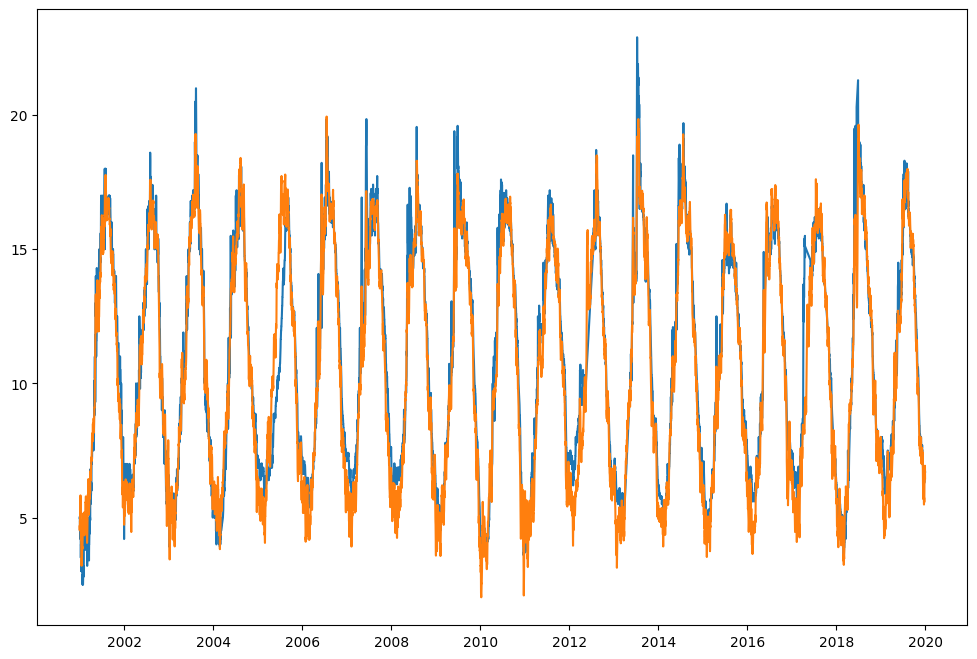

In [70]:
plt.plot(test_df.date, test_df.wt) # Not to shabby
plt.plot(test_df.date, lagged_multi_linear_model.predict(test_df.loc[:, (df.columns != 'wt')&(df.columns != 'date')])) # This appears to be pretty decent 

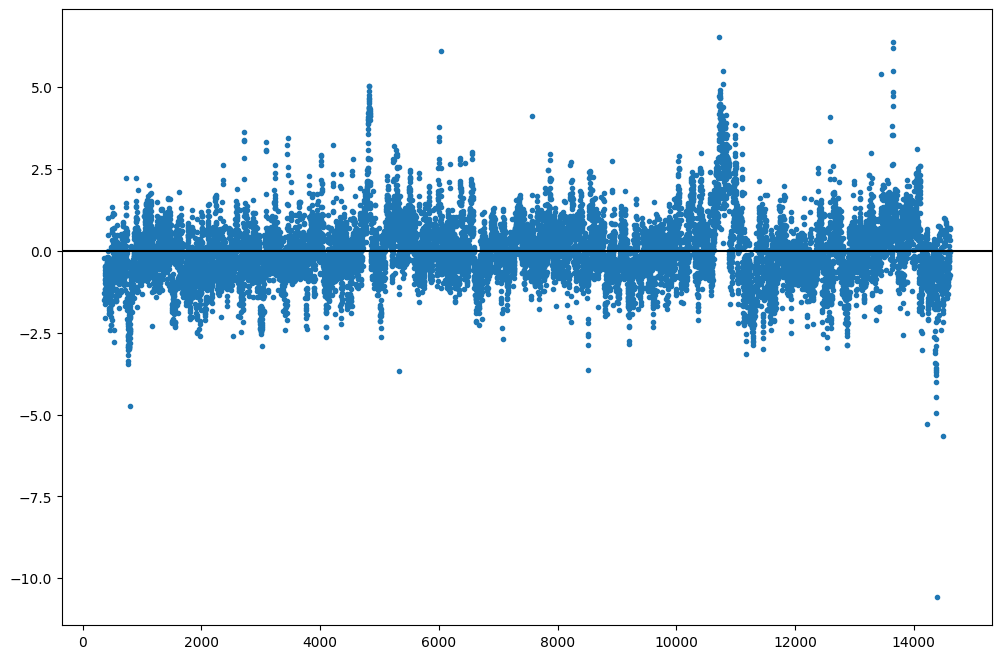

In [71]:
plt.plot(lagged_multi_linear_model.resid, '.')
plt.axhline(0, c = 'k')

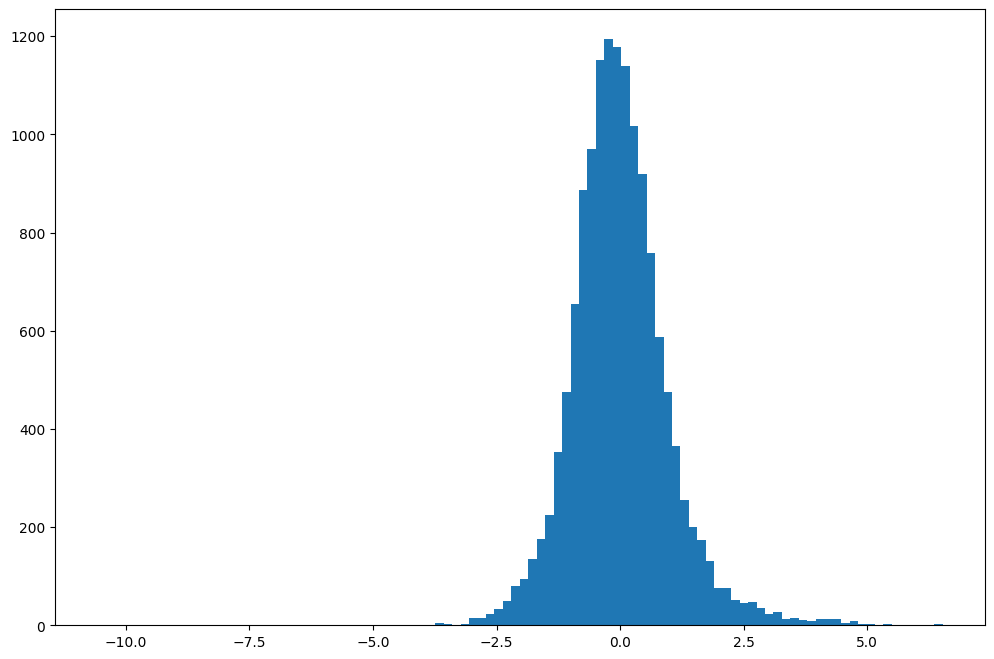

In [72]:
plt.hist(lagged_multi_linear_model.resid, bins = 100);

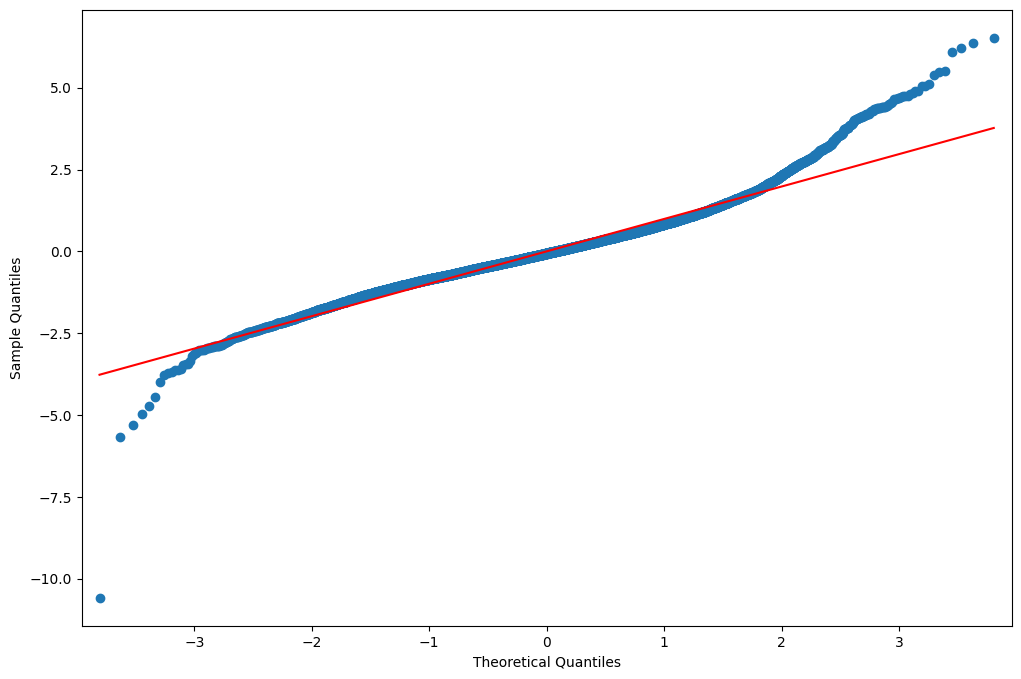

In [73]:
sm.qqplot(lagged_multi_linear_model.resid, line = 's');

Model diagnostics show clear signs of having issues with the lower and upper range of temperatures. This is because water temperature isn't linear with most of these atmospheric data at extreme values.

# Non-linear Models


In [74]:
nonlinear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])

nonlinear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

nonlinear_nn_history = nonlinear_nn.fit(x = x_train['tas'], y = y_train, validation_data=(x_test['tas'], y_test), callbacks = [callback], epochs = 100)

Epoch 1/100
457/457 [==============================] - 2s 2ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 2/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0732 - val_mean_squared_error: 0.0732
Epoch 3/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 4/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 5/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0707 - val_mean_squared_error: 0.0707
Epoch 6/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 7/100
457/457 [=

In [75]:
print('The root mean squared error of the nonlinear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(nonlinear_nn_history.model.predict(x_test['tas'])), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 1ms/step
The root mean squared error of the nonlinear neural network is 2.100162943881979 in degrees celsius.


# Non-linear Multiple Neural Networks

In [76]:
multi_nonlinear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])

multi_nonlinear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

multi_nonlinear_nn_history = multi_nonlinear_nn.fit(x = x_train[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']], y = y_train, validation_data=(x_test[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']], y_test), callbacks = [callback], epochs = 100)

Epoch 1/100
457/457 [==============================] - 2s 2ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 2/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 3/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 4/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 5/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 6/100
457/457 [==============================] - 1s 2ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 7/100
457/457 [=

In [77]:
print('The root mean squared error of the multivariate nonlinear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(multi_nonlinear_nn_history.model.predict(x_test[['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind', 'dayofyear_sin', 'dayofyear_cos']])), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 918us/step
The root mean squared error of the multivariate nonlinear neural network is 1.2768464133433626 in degrees celsius.


## With lagged predictors

In [78]:
lagged_multi_nonlinear_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])

lagged_multi_nonlinear_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.MSE]
)

lagged_multi_nonlinear_nn_history = lagged_multi_nonlinear_nn.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), callbacks = [callback], epochs = 100)

Epoch 1/100
457/457 [==============================] - 2s 2ms/step - loss: 3.0197 - mean_squared_error: 3.0197 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 2/100
457/457 [==============================] - 1s 2ms/step - loss: 3.6636 - mean_squared_error: 3.6636 - val_loss: 0.6837 - val_mean_squared_error: 0.6837
Epoch 3/100
457/457 [==============================] - 1s 2ms/step - loss: 45.2831 - mean_squared_error: 45.2831 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 4/100
457/457 [==============================] - 1s 2ms/step - loss: 39.5128 - mean_squared_error: 39.5128 - val_loss: 0.0582 - val_mean_squared_error: 0.0582
Epoch 5/100
457/457 [==============================] - 1s 2ms/step - loss: 8.1614 - mean_squared_error: 8.1614 - val_loss: 1.3686 - val_mean_squared_error: 1.3686
Epoch 6/100
457/457 [==============================] - 1s 2ms/step - loss: 15.4574 - mean_squared_error: 15.4574 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Epoch 7/100
457/

In [79]:
print('The root mean squared error of the lagged multivariate nonlinear neural network is', sklearn.metrics.mean_squared_error(test_df.wt, y_scaler.inverse_transform(lagged_multi_nonlinear_nn_history.model.predict(x_test)), squared = False), 'in degrees celsius.')

217/217 [==============================] - 0s 968us/step
The root mean squared error of the lagged multivariate nonlinear neural network is 1.1696095699228446 in degrees celsius.


217/217 [==============================] - 0s 846us/step


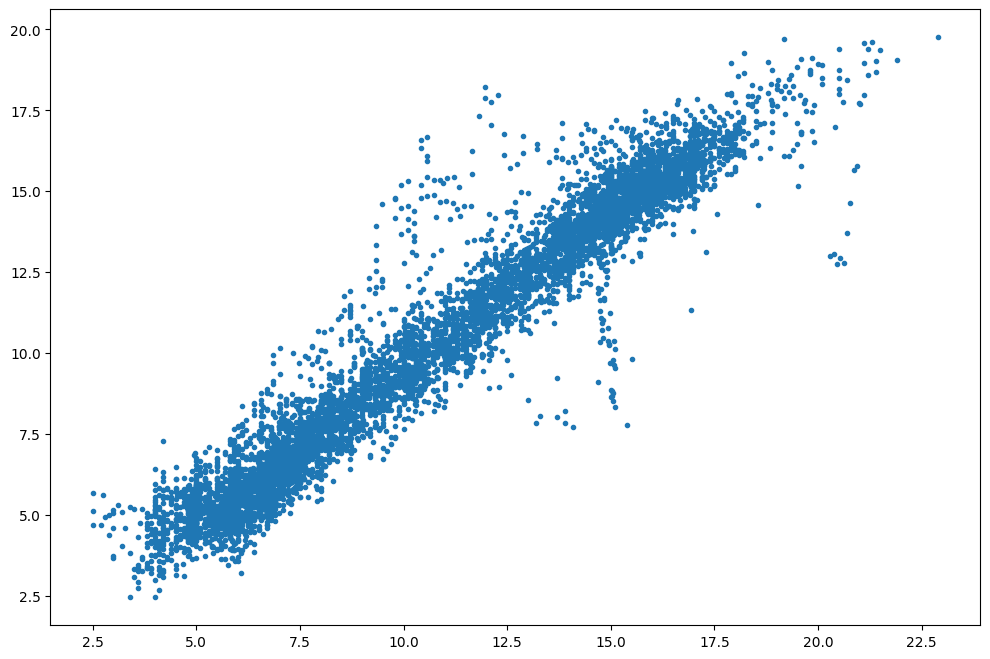

In [80]:
plt.plot(test_df.wt, y_scaler.inverse_transform(lagged_multi_nonlinear_nn_history.model.predict(x_test)), '.') # Not to shabby

217/217 [==============================] - 0s 892us/step


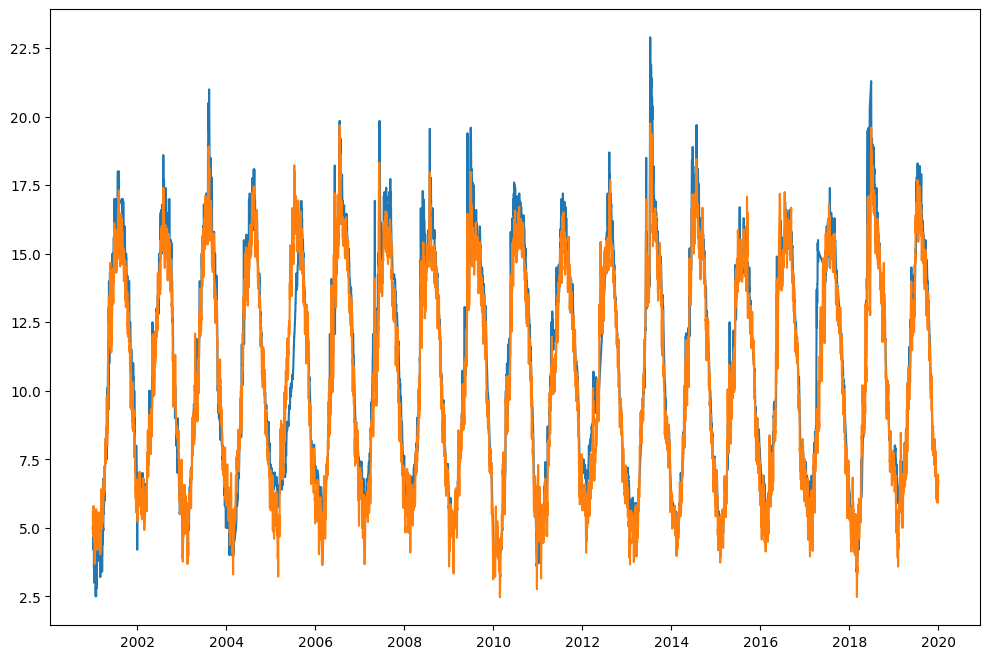

In [81]:
plt.plot(test_df.date, test_df.wt) # Not to shabby
plt.plot(test_df.date, y_scaler.inverse_transform(lagged_multi_nonlinear_nn_history.model.predict(x_test))) # This appears to be pretty decent 

# Long Short-Term Memory Neural Network
The more basic dense layers seem to lose the peaks and sometimes troughs of the temperatures. What if we give it some memory?

The LSTM network takes input in the shape of [batch, time, features]. The convention for creating this is sliding windows, where we slice a time_step length that the model will use to predict value time_step+1. This means that we loose a length of time_step at the beginning of the timeseries.  

In [82]:
x_train_array = np.array(x_train)
y_train_array = np.array(y_train)

x_test_array = np.array(x_test)
y_test_array = np.array(y_test)

print(x_train_array.shape)
print(y_train_array.shape)

(14610, 92)
(14610, 1)


In [83]:
n_past = 365
n_future = 1

lstm_x_train = []
lstm_y_train = []

lstm_x_test = []
lstm_y_test = []

for i in range(n_past, len(x_train_array) - n_future+1):
    lstm_x_train.append(x_train_array[i - n_past:i, 0:x_train_array.shape[1]])
    lstm_y_train.append(y_train_array[i + n_future -1:i + n_future, 0])

lstm_x_train, lstm_y_train = np.array(lstm_x_train), np.array(lstm_y_train)

lstm_x_test = []
lstm_y_test = []

for i in range(n_past, len(x_test_array) - n_future+1):
    lstm_x_test.append(x_test_array[i - n_past:i, 0:x_test_array.shape[1]])
    lstm_y_test.append(y_test_array[i + n_future -1:i + n_future, 0])

lstm_x_test, lstm_y_test = np.array(lstm_x_test), np.array(lstm_y_test)    

In [84]:
print(lstm_x_train.shape)
print(lstm_y_train.shape)
print(lstm_x_test.shape)
print(lstm_y_test.shape)

(14245, 365, 92)
(14245, 1)
(6575, 365, 92)
(6575, 1)


In [85]:
lstm_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99, input_shape = [lstm_x_train.shape[1], lstm_x_train.shape[2]]),
    tf.keras.layers.LSTM(units = 16, return_sequences=False),
    tf.keras.layers.Dense(units = 1)
])

lstm_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MSE]
)

lstm_nn_history = lstm_nn.fit(x = lstm_x_train, y = lstm_y_train, validation_data=(lstm_x_test, lstm_y_test), callbacks = [callback], epochs = 30)

Epoch 1/30
446/446 [==============================] - 48s 100ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 2/30
446/446 [==============================] - 45s 100ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 3/30
446/446 [==============================] - 46s 104ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 4/30
446/446 [==============================] - 43s 96ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 5/30
446/446 [==============================] - 42s 94ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 6/30
446/446 [==============================] - 43s 97ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 7/30
44

In [86]:
print('The root mean squared error of the long short-term memory neural network is', sklearn.metrics.mean_squared_error(test_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1)), squared = False), 'in degrees celsius.')

206/206 [==============================] - 6s 22ms/step
The root mean squared error of the long short-term memory neural network is 1.0495198648246318 in degrees celsius.


206/206 [==============================] - 5s 22ms/step


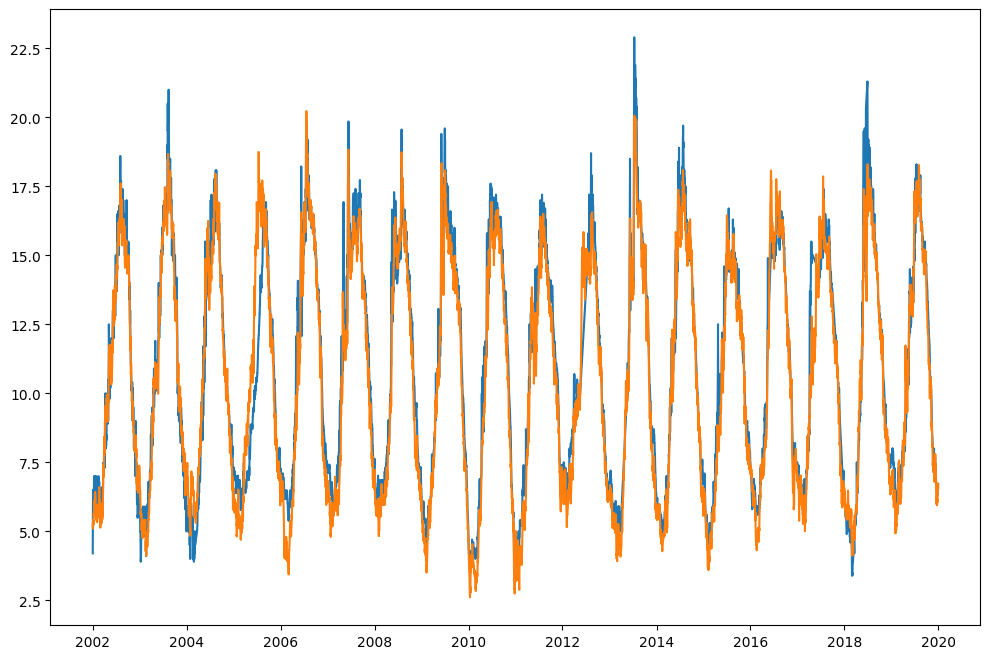

In [87]:
plt.plot(test_df[n_past:].date, test_df[n_past:].wt) # Not to shabby
plt.plot(test_df[n_past:].date, y_scaler.inverse_transform(lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1))) # This appears to be even better

206/206 [==============================] - 5s 23ms/step


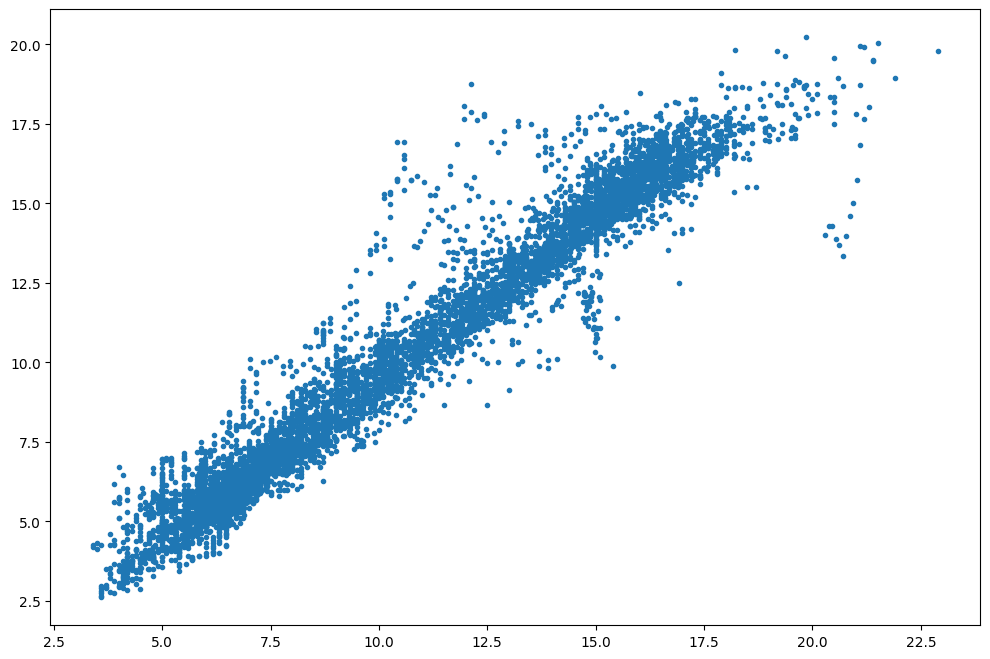

In [88]:
plt.plot(test_df[n_past:].wt, y_scaler.inverse_transform(lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1,1)), '.') # Not to shabby

206/206 [==============================] - 4s 21ms/step


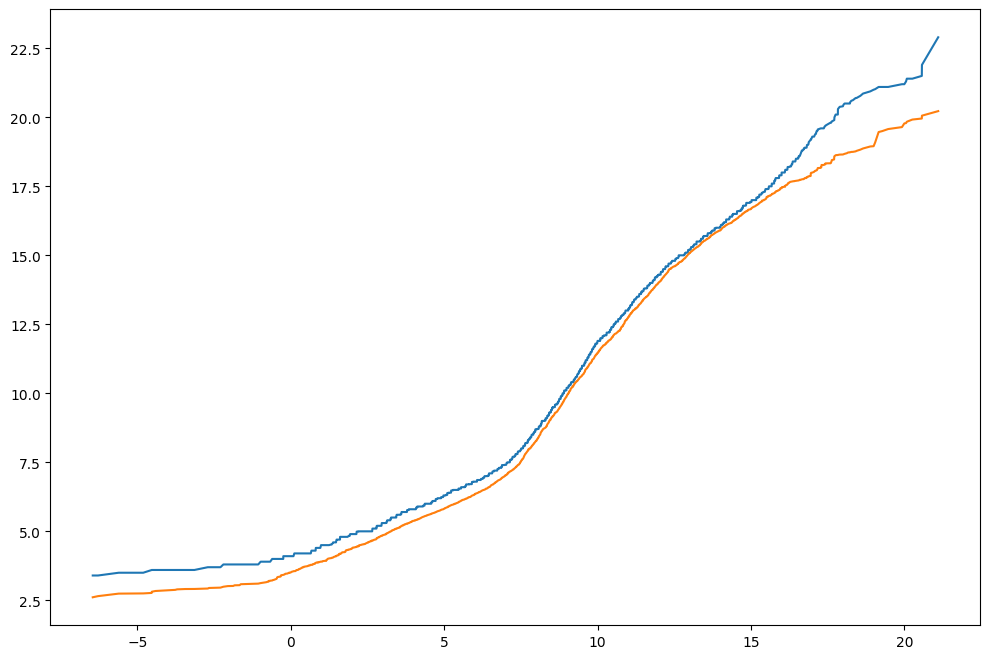

In [89]:
plt.plot(test_df[n_past:].tas.sort_values(), test_df[n_past:].wt.sort_values()) # Not to shabby
plt.plot(test_df[n_past:].tas.sort_values(), np.sort(y_scaler.inverse_transform(lstm_nn_history.model.predict(lstm_x_test)).reshape(-1, 1), axis = 0))

It is apparent that we struggle with predicting the peak temperatures. This may be amended by making it autoregressive, hence feeding itself with its own previous predictions

# Autoregressive LSTM Neural Network

In [90]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, droprate):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.droprate = droprate
        self.mask = tf.keras.layers.Masking(mask_value = -99)
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state = True)
        self.dropout = tf.keras.layers.Dropout(self.droprate)
        self.dense = tf.keras.layers.Dense(1)


In [91]:
auto_lstm_nn = FeedBack(units = 16, out_steps = 1, droprate = 0.1)

In [92]:
def warmup(self, inputs):
    x = self.mask(inputs)
    x, *state = self.lstm_rnn(x)
    x = self.dropout(x)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [93]:
prediction, state = auto_lstm_nn.warmup(lstm_x_train)
prediction.shape


TensorShape([14245, 1])

In [94]:
def call(self, inputs, training = None):
    predictions = []
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)

    for i in range(1, self.out_steps):
        x = prediction
        x, state = self.lstm_cell(x, states = state,
        training =  training)

        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call


In [95]:
auto_lstm_nn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MSE]
)

auto_lstm_nn_history = auto_lstm_nn.fit(x = lstm_x_train, y = lstm_y_train, validation_data=(lstm_x_test, lstm_y_test), callbacks = [callback], epochs = 30)


Epoch 1/30
446/446 [==============================] - 41s 88ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 2/30
446/446 [==============================] - 39s 87ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 3/30
446/446 [==============================] - 41s 92ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 4/30
446/446 [==============================] - 40s 90ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 5/30
446/446 [==============================] - 39s 88ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 6/30
446/446 [==============================] - 39s 88ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 7/30
446/4

In [96]:
auto_lstm_nn.summary()

Model: "feed_back"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_7 (Masking)         multiple                  0         
                                                                 
 lstm_cell_1 (LSTMCell)      multiple                  6976      
                                                                 
 rnn (RNN)                   multiple                  6976      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_13 (Dense)            multiple                  17        
                                                                 
Total params: 6,993
Trainable params: 6,993
Non-trainable params: 0
_________________________________________________________________


In [97]:
print('The root mean squared error of the autoregressive long short-term memory neural network is', sklearn.metrics.mean_squared_error(test_df.wt[n_past:], y_scaler.inverse_transform(auto_lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1)), squared = False), 'in degrees celsius.')

206/206 [==============================] - 5s 26ms/step
The root mean squared error of the autoregressive long short-term memory neural network is 1.0824615014257422 in degrees celsius.


206/206 [==============================] - 6s 29ms/step


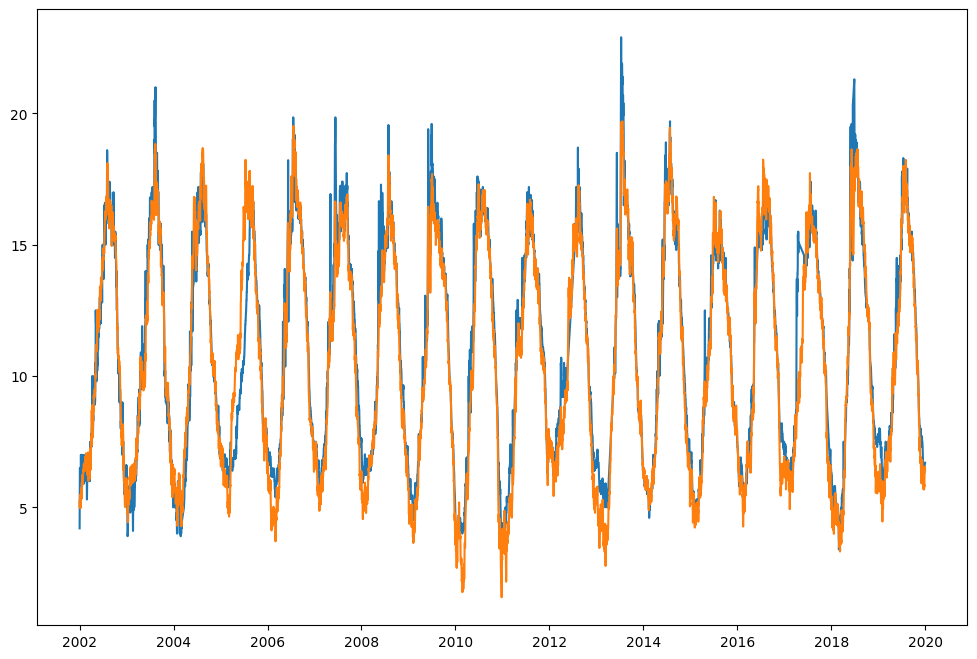

In [98]:
plt.plot(test_df[n_past:].date, test_df[n_past:].wt) # Not to shabby
plt.plot(test_df[n_past:].date, y_scaler.inverse_transform(auto_lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1))) # This appears to be even better

206/206 [==============================] - 6s 30ms/step


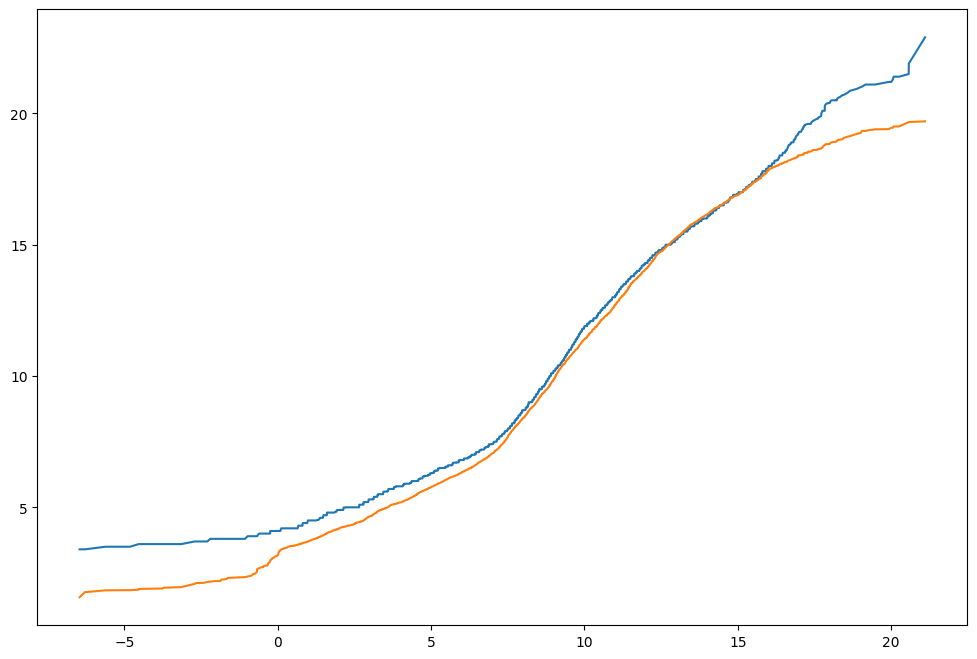

In [99]:
plt.plot(test_df[n_past:].tas.sort_values(), test_df[n_past:].wt.sort_values()) # Not to shabby
plt.plot(test_df[n_past:].tas.sort_values(), np.sort(y_scaler.inverse_transform(auto_lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1)), axis = 0))

# The two contestants:

- LSTM
- Autoregressive LSTM


In [100]:
print('The root mean squared error of the long short-term memory neural network is', sklearn.metrics.mean_squared_error(test_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1)), squared = False), 'in degrees celsius.')
print('The root mean squared error of the autoregressive long short-term memory neural network is', sklearn.metrics.mean_squared_error(test_df.wt[n_past:], y_scaler.inverse_transform(auto_lstm_nn_history.model.predict(lstm_x_test).flatten().reshape(-1, 1)), squared = False), 'in degrees celsius.')

206/206 [==============================] - 6s 30ms/step
The root mean squared error of the long short-term memory neural network is 1.0495198648246318 in degrees celsius.
206/206 [==============================] - 5s 24ms/step
The root mean squared error of the autoregressive long short-term memory neural network is 1.0824615014257422 in degrees celsius.
